**Big Data Bowl 2025**

**Collin LaButte  
Metric Track**


# Report

In recent years, passing has increasingly become the preferred method of advancing the ball in the NFL, surpassing rushing in popularity. In 2023 alone, passing plays accounted for 55.6% of all plays (FFToday). This shift underscores the importance of defenses being able to counteract passing strategies effectively. To address this challenge, I developed a model to predict the most likely route a wide receiver will run based on pre-snap formations and game situations.

With the abundance of data available in the dataset, I implemented a gradient-boosting algorithm (XGBoost) to leverage the extensive training opportunities the model could benefit from. During feature selection, I focused on several key areas to enhance predictive accuracy:

1. In-Game Situational Factors: These included variables like the game clock, yardline position, down, and yards to go. Such factors directly influence play-calling decisions and the routes receivers are likely to run.

2. Receiver Alignment: This encompassed the x and y coordinates from tracking data and the alignment variable, which indicates the distribution of receivers on each side of the field.

3. Defensive Coverage: Variables such as the type of pass coverage and whether the defense was playing man-to-man or zone coverage were critical in modeling route predictions.

4. Pre-Snap Movement: This area considered pre-snap shifts or motions by the receiver or other players, which can provide insights into which route a receiver is likely to run.

5. Player Route Tendencies: By incorporating the receiver's unique identifier (nflId), I accounted for individual tendencies in route selection based on historical data.

For the model, I used wide receiver data from the entire NFL rather than focusing on a single team’s offense. This broader dataset significantly enhanced the model’s learning capabilities, enabling it to predict receiver routes with approximately 20% greater accuracy compared to using data limited to an individual team.  

After data cleaning and processing, the final dataset consisted of 16,689 observations. These were split into 80% training data (13,352 observations) and 20% testing data (3,337 observations) to ensure strong evaluation. In the model's best iteration, the training loss was 1.6697, while the testing loss reached 2.0209.

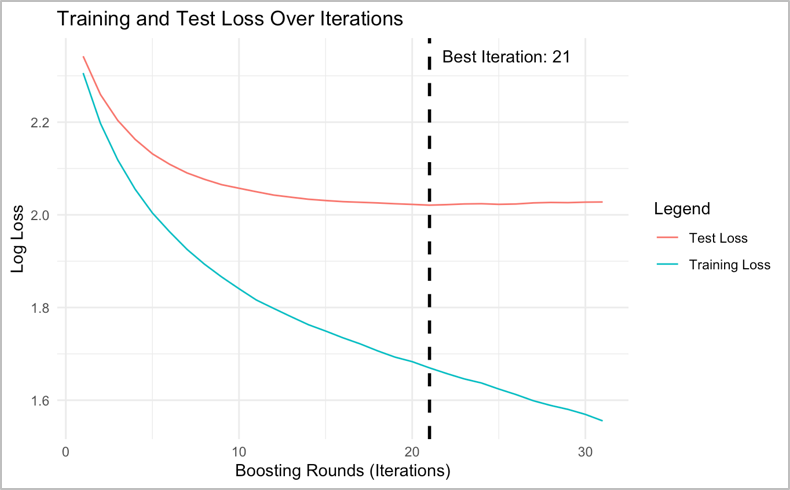

In the model output, the top three routes with the highest predicted probabilities for each receiver were calculated. Given the variability in play design and route types, predicting the exact route is challenging. However, identifying the top three likely routes offers a more practical and actionable approach.  

The model achieved an accuracy of 58.38%, meaning that over 58% of the time, the actual route run by the receiver was among the top three predicted routes. When examining accuracy by rank of prediction, the most likely predicted route was correct 25.8% of the time. This highlights the value of incorporating multiple predictions to better capture the complexity of route selection.  

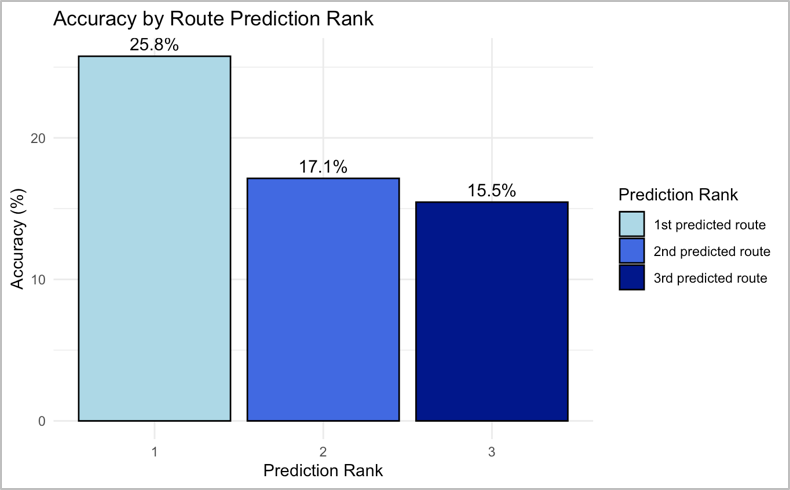

In a separate analysis of route type prediction accuracy, the out, cross, hitch, and go routes ranked as the most accurately predicted. Notably, the go route was correctly predicted just over 30% of the time.  

This insight can provide valuable context for defensive coordinators, as it suggests that the model is more reliable when predicting these specific route types. Based on this observation, defensive strategies could be adjusted with greater confidence when one of these four routes is identified, as opposed to others that may be inherently harder to anticipate.

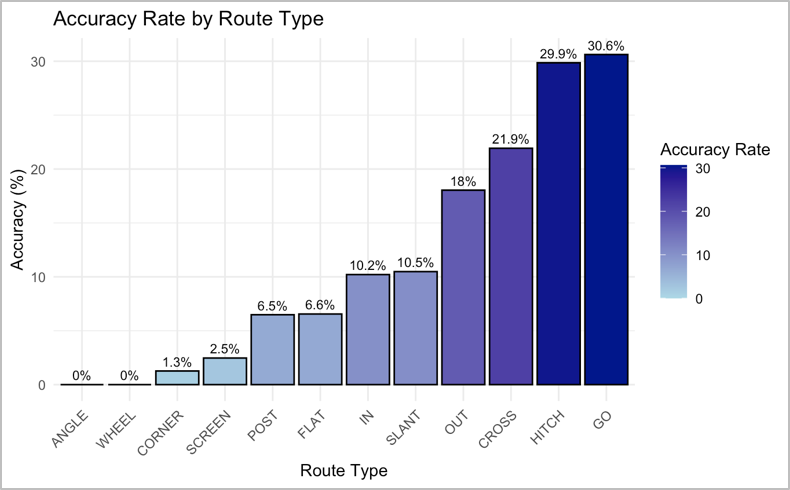

When analyzing feature importance in the model, several factors emerged as key predictors of route types. The most influential feature was the y position of the wide receiver from the tracking data. This feature held significant predictive power because a receiver's horizontal alignment often indicates the type of route they are likely to run. For example, receivers lining up on the outside are more inclined to run deep routes, while slot receivers typically execute shorter, sharper routes.

Other highly important features included the receiver’s nflId, game clock, and x position. The inclusion of nflId highlights that certain receivers exhibit consistent tendencies in the types of routes they run. The game clock underscores the influence of game timing on route selection, as certain stages of a game may dictate specific play types. The x position reflects the importance of field positioning, as route types can vary depending on how close the team is to their end zone or their opponents.

While additional factors in the model contributed to its predictive accuracy, these four variables stood out as the most impactful, offering valuable insights into the dynamics of route prediction.

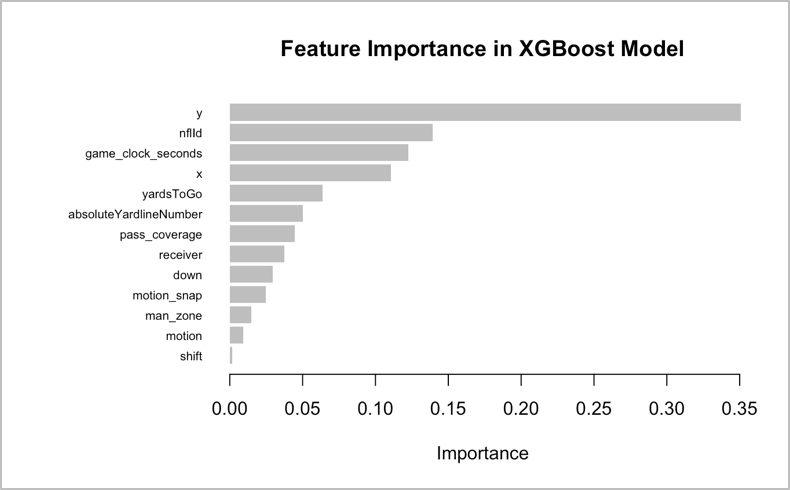

This model and analysis are valuable value for NFL teams by providing accurate predictions of which route an opposing wide receiver is most likely to run. Such insights would enable defensive backs to better strategize for critical game situations, including pivotal moments like 3rd downs or plays in the red zone. 

The ability to predict routes offers a distinct competitive advantage, especially when facing highly talented wide receivers. By knowing the routes a receiver is most likely to run, defensive players can position themselves more effectively, potentially neutralizing big-play threats and limiting explosive gains. This level of preparation becomes particularly critical in matchups against elite receivers where even small insights can make a significant difference.

Furthermore, with a larger dataset spanning multiple seasons, similar models could be tailored for team-specific analysis, capturing trends unique to individual players or team schemes. These extended insights could help teams identify career shifts, adapt to evolving play styles, and exploit opponent tendencies.

Overall, this model provides a framework for understanding player and situational tendencies, factoring in variables such as pass coverages, pre-snap movements, and receiver positioning. By integrating this approach, NFL teams can enhance their defensive strategies, improve in-game decision-making, and gain an edge in critical matchups.

# Appendix

# Data and Package Loading

In [1]:
tracking_data_wk1 <- read.csv("/kaggle/input/nfl-big-data-bowl-2025/tracking_week_1.csv")
tracking_data_wk2 <- read.csv("/kaggle/input/nfl-big-data-bowl-2025/tracking_week_2.csv")
tracking_data_wk3 <- read.csv("/kaggle/input/nfl-big-data-bowl-2025/tracking_week_3.csv")
tracking_data_wk4 <- read.csv("/kaggle/input/nfl-big-data-bowl-2025/tracking_week_4.csv")
tracking_data_wk5 <- read.csv("/kaggle/input/nfl-big-data-bowl-2025/tracking_week_5.csv")
tracking_data_wk6 <- read.csv("/kaggle/input/nfl-big-data-bowl-2025/tracking_week_6.csv")
tracking_data_wk7 <- read.csv("/kaggle/input/nfl-big-data-bowl-2025/tracking_week_7.csv")
tracking_data_wk8 <- read.csv("/kaggle/input/nfl-big-data-bowl-2025/tracking_week_8.csv")
tracking_data_wk9 <- read.csv("/kaggle/input/nfl-big-data-bowl-2025/tracking_week_9.csv")

In [2]:
player_data <- read.csv("/kaggle/input/nfl-big-data-bowl-2025/players.csv")
game_data <- read.csv("/kaggle/input/nfl-big-data-bowl-2025/games.csv")
play_data <- read.csv("/kaggle/input/nfl-big-data-bowl-2025/plays.csv")
player_play_data <- read.csv("/kaggle/input/nfl-big-data-bowl-2025/player_play.csv")

In [3]:
library(dplyr)
library(xgboost)
library(caret)
library(ggplot2)


Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union





Attaching package: ‘xgboost’




The following object is masked from ‘package:dplyr’:

    slice




Loading required package: ggplot2



Loading required package: lattice




Attaching package: ‘caret’




The following object is masked from ‘package:httr’:

    progress




# Data Processing

The play and player datasets were joined and filtered to only include wide receivers.

In [4]:
base_data <- player_play_data

base_data <- base_data %>%
  left_join(play_data , by = c("gameId", "playId"))

base_data <- base_data %>%
  left_join(player_data %>% select(displayName, nflId, position), by = "nflId")

base_data <- base_data[base_data$position %in% c("WR"), ]

Only relevant variables for the model were kept.

In [5]:
base_data <- base_data %>%
  select(
     gameId, playId, nflId, displayName, position, teamAbbr, hadPassReception, 
    receivingYards, wasTargettedReceiver, yardageGainedAfterTheCatch, 
    inMotionAtBallSnap, shiftSinceLineset, motionSinceLineset, wasRunningRoute, 
    routeRan, pff_defensiveCoverageAssignment, pff_primaryDefensiveCoverageMatchupNflId,  playDescription, quarter, down, yardsToGo, defensiveTeam, yardlineSide, 
    yardlineNumber, gameClock, absoluteYardlineNumber, playNullifiedByPenalty, 
    offenseFormation, receiverAlignment, passResult, passLength, targetX, 
    targetY, passLocationType, timeToThrow, pff_passCoverage, pff_manZone
  )

Variable encoding was done for categorical variables because the XGBoost model can only have numerical inputs.

In [6]:
route_labels <- levels(as.factor(base_data$routeRan))
base_data$routeRan_encoded <- as.integer(as.factor(base_data$routeRan)) - 1

route_mapping <- data.frame(
  Route = route_labels,
  Encoded = seq_along(route_labels) - 1
)

base_data$man_zone <- ifelse(base_data$pff_manZone == "Man", 0, 
                           ifelse(base_data$pff_manZone == "Zone", 1, NA))
base_data$shift <- ifelse(base_data$shiftSinceLineset == "FALSE", 0, 
                           ifelse(base_data$shiftSinceLineset == "TRUE", 1, NA))
base_data$motion_snap <- ifelse(base_data$inMotionAtBallSnap == "FALSE", 0, 
                           ifelse(base_data$inMotionAtBallSnap == "TRUE", 1, NA))
base_data$motion <- ifelse(base_data$motionSinceLineset == "FALSE", 0, 
                           ifelse(base_data$motionSinceLineset == "TRUE", 1, NA))
base_data$receiver <- as.integer(as.factor(base_data$receiverAlignment)) - 1
base_data$pass_coverage <- as.integer(as.factor(base_data$pff_passCoverage)) - 1

The game clock variable was manipulated to numerical format.

In [7]:
base_data$game_clock_seconds <- sapply(base_data$gameClock, function(clock) {
  if (!is.na(clock)) {
    time_parts <- strsplit(clock, ":")[[1]]
    minutes <- as.integer(time_parts[1]) 
    seconds <- as.integer(time_parts[2]) 
    total_seconds <- minutes * 60 + seconds
    return(total_seconds)
  } else {
    return(NA)
  }
})

All tracking data was filtered to only show x and y data at the snap of the ball so as not to confuse the model with non-relevant positional data.

In [8]:
wk1 <- tracking_data_wk1[tracking_data_wk1$frameType %in% c("SNAP"), ]
wk2 <- tracking_data_wk2[tracking_data_wk2$frameType %in% c("SNAP"), ]
wk3 <- tracking_data_wk3[tracking_data_wk3$frameType %in% c("SNAP"), ]
wk4 <- tracking_data_wk4[tracking_data_wk4$frameType %in% c("SNAP"), ]
wk5 <- tracking_data_wk5[tracking_data_wk5$frameType %in% c("SNAP"), ]
wk6 <- tracking_data_wk6[tracking_data_wk6$frameType %in% c("SNAP"), ]
wk7 <- tracking_data_wk7[tracking_data_wk7$frameType %in% c("SNAP"), ]
wk8 <- tracking_data_wk8[tracking_data_wk8$frameType %in% c("SNAP"), ]
wk9 <- tracking_data_wk9[tracking_data_wk9$frameType %in% c("SNAP"), ]

In [9]:
tracking_binded_data <- rbind(wk1, wk2, wk3, wk4, wk5, wk6, wk7, wk8, wk9)

base_data <- base_data %>%
  left_join(tracking_binded_data %>% select(gameId, playId, nflId, y, x), 
            by = c("gameId", "playId","nflId"))

In [10]:
data <- base_data[, c("routeRan_encoded", "man_zone", "absoluteYardlineNumber","shift", "motion_snap", "motion", "receiver","nflId","down","yardsToGo","pass_coverage","game_clock_seconds","gameId", "playId", "y", "x")]

# Model Creation

Data was split into training and testing datasets.

In [11]:
data <- na.omit(data)
set.seed(123) 
train_idx <- createDataPartition(data$routeRan_encoded, p = 0.8, list = FALSE)
train_data <- data[train_idx, ]
test_data <- data[-train_idx, ]

Feature columns were selected.

In [12]:
exclude_cols <- c("routeRan_encoded", "playId", "gameId") 

feature_cols <- setdiff(names(train_data), exclude_cols)

train_x <- as.matrix(train_data[, feature_cols])
train_y <- train_data$routeRan_encoded
test_x <- as.matrix(test_data[, feature_cols])
test_y <- test_data$routeRan_encoded

The XGBoost model was created, trained, and tested.

In [13]:
dtrain <- xgb.DMatrix(data = train_x, label = train_y)
dtest <- xgb.DMatrix(data = test_x, label = test_y)

params <- list(
  objective = "multi:softprob", 
  num_class = length(unique(train_y)), 
  eval_metric = "mlogloss"      
)

xgb_model <- xgb.train(
  params = params,
  data = dtrain,
  nrounds = 100,  
  watchlist = list(train = dtrain, test = dtest),
  early_stopping_rounds = 10, 
  verbose = 1
)

[1]	train-mlogloss:2.306041	test-mlogloss:2.342276 
Multiple eval metrics are present. Will use test_mlogloss for early stopping.
Will train until test_mlogloss hasn't improved in 10 rounds.

[2]	train-mlogloss:2.197301	test-mlogloss:2.259587 
[3]	train-mlogloss:2.118471	test-mlogloss:2.203690 
[4]	train-mlogloss:2.055453	test-mlogloss:2.162997 
[5]	train-mlogloss:2.004066	test-mlogloss:2.131626 
[6]	train-mlogloss:1.963205	test-mlogloss:2.108974 
[7]	train-mlogloss:1.925445	test-mlogloss:2.090411 
[8]	train-mlogloss:1.893702	test-mlogloss:2.076746 
[9]	train-mlogloss:1.865915	test-mlogloss:2.065073 
[10]	train-mlogloss:1.840588	test-mlogloss:2.057398 
[11]	train-mlogloss:1.816255	test-mlogloss:2.049863 
[12]	train-mlogloss:1.798119	test-mlogloss:2.042682 
[13]	train-mlogloss:1.780344	test-mlogloss:2.038083 
[14]	train-mlogloss:1.763065	test-mlogloss:2.033692 
[15]	train-mlogloss:1.749274	test-mlogloss:2.030906 
[16]	train-mlogloss:1.734666	test-mlogloss:2.028481 
[17]	train-mlogloss:1

# Model Evaluation

Plot for training and testing loss.

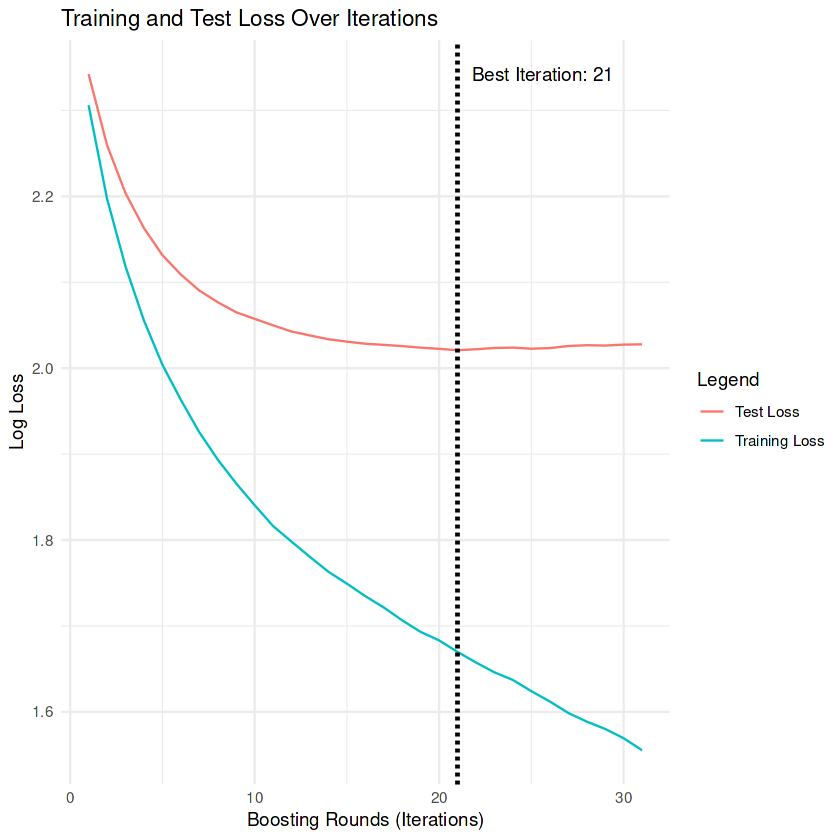

In [14]:
eval_log <- xgb_model$evaluation_log

best_iteration <- which.min(eval_log$test_mlogloss)

ggplot(eval_log, aes(x = iter)) +
  geom_line(aes(y = train_mlogloss, color = "Training Loss")) +
  geom_line(aes(y = test_mlogloss, color = "Test Loss")) +
  geom_vline(xintercept = best_iteration, linetype = "dashed", color = "black", linewidth = 1) +
  annotate(
    "text",
    x = best_iteration,
    y = max(eval_log$test_mlogloss),
    label = paste("Best Iteration:", best_iteration),
    hjust = -0.1,
    color = "black"
  ) +
  labs(
    title = "Training and Test Loss Over Iterations",
    x = "Boosting Rounds (Iterations)",
    y = "Log Loss",
    color = "Legend"
  ) +
  theme_minimal()

The model is used in a prediction of the test dataset.

In [15]:
pred_prob <- predict(xgb_model, newdata = dtest)

num_classes <- length(unique(test_y)) 
pred_matrix <- matrix(pred_prob, ncol = num_classes, byrow = TRUE)

game_ids <- test_data$gameId
play_ids <- test_data$playId
receivers <- test_data$nflId 

get_top_n_predictions <- function(row, n = 3) {
  top_indices <- order(row, decreasing = TRUE)[1:n]
  top_probs <- row[top_indices] 
  return(data.frame(Route = top_indices - 1, Probability = top_probs)) 
}

top_3_predictions <- bind_rows(lapply(seq_len(nrow(pred_matrix)), function(i) {
  cbind(Observation = i, 
        gameId = game_ids[i], 
        playId = play_ids[i],
        receiver = receivers[i], 
        get_top_n_predictions(pred_matrix[i, ], n = 3))
}))

head(top_3_predictions)

top_3_predictions <- top_3_predictions %>%
  left_join(test_data %>% select(gameId, playId, nflId, routeRan_encoded), 
            by = c("gameId", "playId", "receiver" = "nflId"))

,Observation,gameId,playId,receiver,Route,Probability
,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,1,2022090800,167,44985,4,0.41717976
2,1,2022090800,167,44985,5,0.16834393
3,1,2022090800,167,44985,6,0.09093517
4,2,2022090800,212,42818,4,0.34803349
5,2,2022090800,212,42818,10,0.21100827
6,2,2022090800,212,42818,5,0.15847678


Accuracy calculation.

In [16]:
top_3_predictions <- top_3_predictions %>%
  mutate(route_match_flag = ifelse(Route == routeRan_encoded, 1, 0))

accuracy <- sum(top_3_predictions$route_match_flag == 1, na.rm = TRUE) / (nrow(top_3_predictions) / 3)
print(paste("Accuracy:", round(accuracy * 100, 2), "%"))

[1] "Accuracy: 58.38 %"


# Analysis

Accuracy by route prediction number.

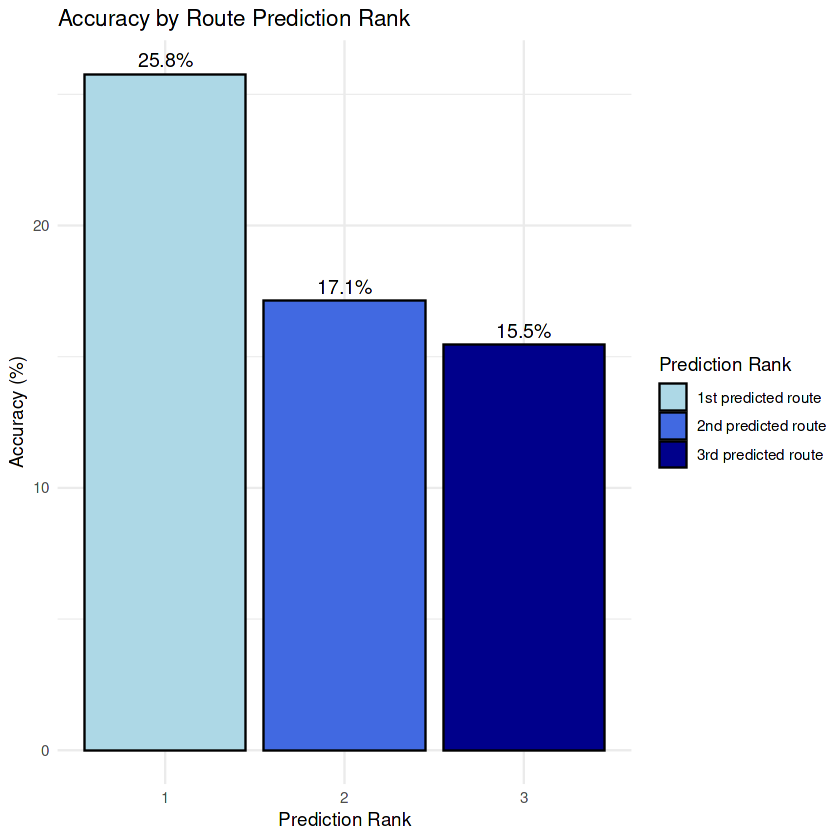

In [17]:
top_3_predictions <- top_3_predictions %>%
  group_by(Observation) %>%
  mutate(rank = row_number()) %>%
  ungroup()

accuracy_by_rank <- top_3_predictions %>%
  group_by(rank) %>%
  summarize(
    correct_count = sum(route_match_flag, na.rm = TRUE),
    total_count = n(),
    accuracy = correct_count / total_count * 100
  )

ggplot(accuracy_by_rank, aes(x = factor(rank), y = accuracy, fill = factor(rank))) +
  geom_bar(stat = "identity", color = "black") +
  geom_text(aes(label = paste0(round(accuracy, 1), "%")), 
            vjust = -0.5, size = 4) + 
  labs(
    title = "Accuracy by Route Prediction Rank",
    x = "Prediction Rank",
    y = "Accuracy (%)",
    fill = "Prediction Rank"
  ) +
  theme_minimal() +
  scale_fill_manual(
    values = c("lightblue", "royalblue", "darkblue"),
    labels = c("1st predicted route", "2nd predicted route", "3rd predicted route")
  )

Accuracy by route type.

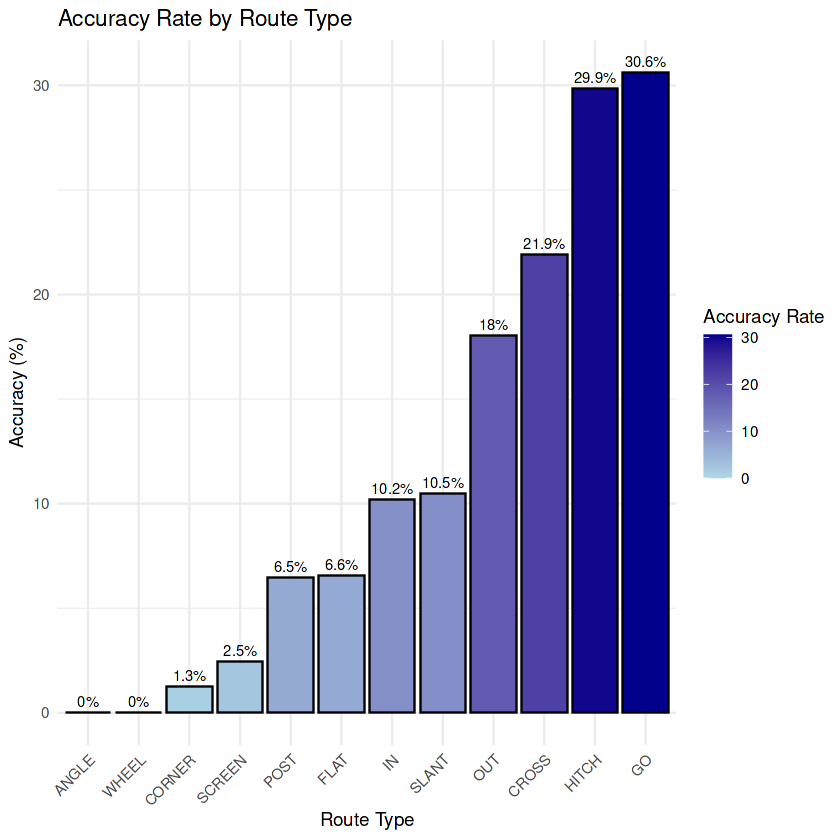

In [18]:
success_by_route <- top_3_predictions %>%
  group_by(routeRan_encoded) %>%
  summarize(
    correct_count = sum(route_match_flag, na.rm = TRUE),
    total_count = n(),
    success_rate = correct_count / total_count * 100
  )

success_by_route <- success_by_route %>%
  left_join(route_mapping, by = c("routeRan_encoded" = "Encoded"))

ggplot(success_by_route, aes(x = reorder(Route, success_rate), y = success_rate, fill = success_rate)) +
  geom_bar(stat = "identity", color = "black") +
  geom_text(aes(label = paste0(round(success_rate, 1), "%")), 
            vjust = -0.5, size = 3) +  
  labs(
    title = "Accuracy Rate by Route Type",
    x = "Route Type",
    y = "Accuracy (%)",
    fill = "Accuracy Rate"
  ) +
  theme_minimal() +
  scale_fill_gradient(low = "lightblue", high = "darkblue") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

Feature importance matrix in XGBoost model.

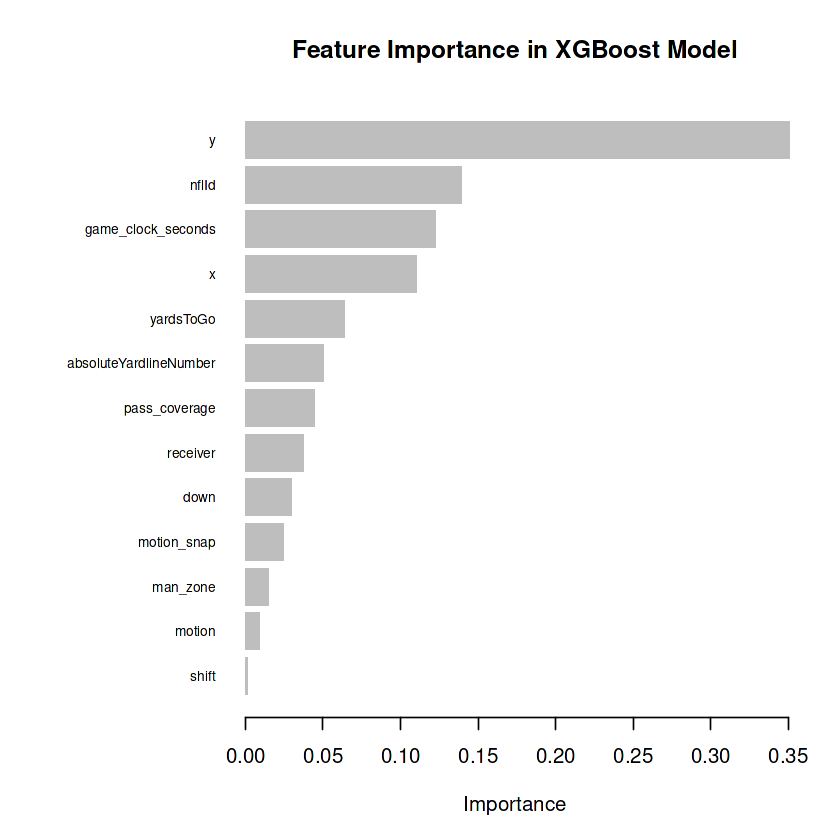

In [19]:
importance_matrix <- xgb.importance(model = xgb_model)

importance_plot <- xgb.plot.importance(importance_matrix, 
                                       main = "Feature Importance in XGBoost Model", 
                                       xlab = "Importance")